# Respiratory Disease Classifier

## Workflow

1. Image Data -> Data Curation
2. Data Processing
3. Data Splitting

    a) Training data

    b) Test data

4. CNN Training
5. Model Evaluation
6. Build a web app

### Seeding libraries for reproducibility

In [ ]:
!pip install tensorflow

In [ ]:
# Set seeds for reproducibility
import random
random.seed(0)

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.random.set_seed(0)

### Importing the dependencies

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from zipfile import ZipFile
from PIL import Image
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import os

import wave
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from IPython.display import Audio
import librosa
import librosa.display
#from keras import np_utils
#from keras.layers import concatenate
from tensorflow.keras.models import Sequential, Model, load_model

from tensorflow.keras.layers import Conv1D, Conv2D, SeparableConv1D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import Input, add, Flatten, Dense, BatchNormalization, Dropout, LSTM, GRU
from tensorflow.keras.layers import GlobalMaxPooling1D, GlobalMaxPooling2D, Activation, LeakyReLU, ReLU

# from tensorflow.keras.layers import Embedding,LSTM,GRU,Dense,MaxPooling1D,Dropout, Input
# from tensorflow.keras.layers import LeakyReLU,ReLU,Flatten,concatenate,Bidirectional,TimeDistributed
# from tensorflow.keras.layers import add,Conv1D,SeparableConv1D, GlobalMaxPooling2D,GlobalMaxPooling1D
# from tensorflow.keras.layers import Conv2D,Input,Activation,BatchNormalization,MaxPooling2D

from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
from sklearn.metrics import cohen_kappa_score,roc_auc_score,confusion_matrix,classification_report

## Data curation

In [ ]:
kaggle_credentials = json.load(open("kaggle.json"))

In [ ]:
# Setup kaggle API key as environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_credentials["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentials["key"]

### Downloading dataset

In [ ]:
!kaggle datasets download -d vbookshelf/respiratory-sound-database

100% 3.69G/3.69G [01:38<00:00, 40.6MB/s]
100% 3.69G/3.69G [01:38<00:00, 40.3MB/s]


### Extracting Dataset

In [ ]:
# Unzip the downloaded dataset

zip_file_path = '/content/respiratory-sound-database.zip'

with ZipFile(zip_file_path, 'r') as zip_ref:
  zip_ref.extractall()

In [ ]:
audio_data = 'Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'

In [ ]:
patient_data=pd.read_csv('Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv',names=['pid','disease'])

In [ ]:
diagnosis_df = pd.read_csv('Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv', names=['patient_id', 'disease'])
diagnosis_df.head(4)

,patient_id,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD


### Analysing Dataset

In [ ]:
print(diagnosis_df.disease.value_counts())

disease
COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Bronchiolitis      6
Pneumonia          6
LRTI               2
Asthma             1
Name: count, dtype: int64


In [ ]:
print(diagnosis_df.disease.value_counts(normalize=True) *100)

disease
COPD              50.793651
Healthy           20.634921
URTI              11.111111
Bronchiectasis     5.555556
Bronchiolitis      4.761905
Pneumonia          4.761905
LRTI               1.587302
Asthma             0.793651
Name: proportion, dtype: float64


### Data Visualisation

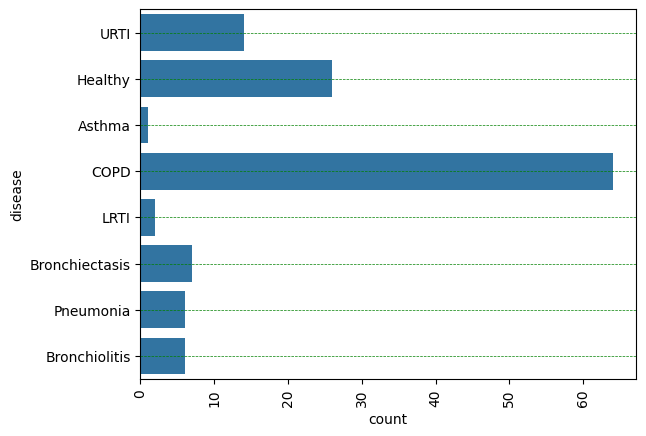

In [ ]:
sns.countplot(diagnosis_df.disease)
plt.grid(axis = 'y',color = 'green', linestyle = '--', linewidth = 0.5)
plt.xticks(rotation=90)
plt.show()

In [ ]:
path='Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]

In [ ]:
files[:10]

['113_1b1_Pr_sc_Litt3200',
 '192_2b2_Ar_mc_LittC2SE',
 '178_1b2_Pr_mc_AKGC417L',
 '151_2p4_Pl_mc_AKGC417L',
 '177_1b4_Ar_mc_AKGC417L',
 '158_1p2_Tc_mc_AKGC417L',
 '198_6p1_Ar_mc_AKGC417L',
 '213_1p2_Al_mc_AKGC417L',
 '183_1b1_Tc_sc_Meditron',
 '151_2p3_Ll_mc_AKGC417L']

## Data Augmentation

In [ ]:
def add_noise(data,x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data,x):
    return np.roll(data, x)

def stretch(data, rate):
    data = librosa.effects.time_stretch(y=data, rate=rate)
    return data

def pitch_shift (data , rate):
    data = librosa.effects.pitch_shift(data, sr=220250, n_steps=rate)
    return data

In [ ]:
def show_audio(audio_path):
    y, sr = librosa.load(audio_path)
    y_noise = add_noise(y , 0.0008)
    y_shift = shift(y,3200)
    y_stretch_1 = stretch(y, 1.2)
    y_stretch_2 = stretch(y, 0.8)
    y_pitch_shift = pitch_shift(y, 3)

    plt.figure(figsize=(20, 8))

    plt.subplot(3,2,1)
    librosa.display.waveshow(y, sr=sr)
    plt.title('orginal')

    plt.subplot(3,2,2)
    librosa.display.waveshow(y_noise, sr=sr)
    plt.title('noise')

    plt.subplot(3,2,3)
    librosa.display.waveshow(y_shift, sr=sr)
    plt.title('shift')

    plt.subplot(3,2,4)
    librosa.display.waveshow(y_stretch_1, sr=sr)
    plt.title('stretch 1')

    plt.subplot(3,2,5)
    librosa.display.waveshow(y_stretch_2, sr=sr)
    plt.title('stretch 2')

    plt.subplot(3,2,6)
    librosa.display.waveshow(y_pitch_shift, sr=sr)
    plt.title('pitch shift')

    plt.tight_layout()

In [ ]:
def show_audio_features(audio_path):
    y, sr = librosa.load(audio_path)
    y_noise = add_noise(y , 0.0008)
    y_shift = shift(y,3200)
    y_stretch_1 = stretch(y, 1.2)
    y_stretch_2 = stretch(y, 0.8)
    y_pitch_shift = pitch_shift(y, 3)

    y = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=50)
    y_noise = librosa.feature.mfcc(y=y_noise, sr=sr, n_mfcc=50)
    y_shift = librosa.feature.mfcc(y=y_shift, sr=sr, n_mfcc=50)
    y_stretch_1 = librosa.feature.mfcc(y=y_stretch_1, sr=sr, n_mfcc=50)
    y_stretch_2 = librosa.feature.mfcc(y=y_stretch_2, sr=sr, n_mfcc=50)
    y_pitch_shift = librosa.feature.mfcc(y=y_pitch_shift, sr=sr, n_mfcc=50)

    plt.figure(figsize=(20, 8))

    plt.subplot(3,2,1)
    librosa.display.specshow(librosa.power_to_db(y,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('orginal')

    plt.subplot(3,2,2)
    librosa.display.specshow(librosa.power_to_db(y_noise,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('noise')

    plt.subplot(3,2,3)
    librosa.display.specshow(librosa.power_to_db(y_shift,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('shift')

    plt.subplot(3,2,4)
    librosa.display.specshow(librosa.power_to_db(y_stretch_1,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('stretch 1')

    plt.subplot(3,2,5)
    librosa.display.specshow(librosa.power_to_db(y_stretch_2,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('stretch 2')

    plt.subplot(3,2,6)
    librosa.display.specshow(librosa.power_to_db(y_pitch_shift,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('pitch shift')



    plt.tight_layout()

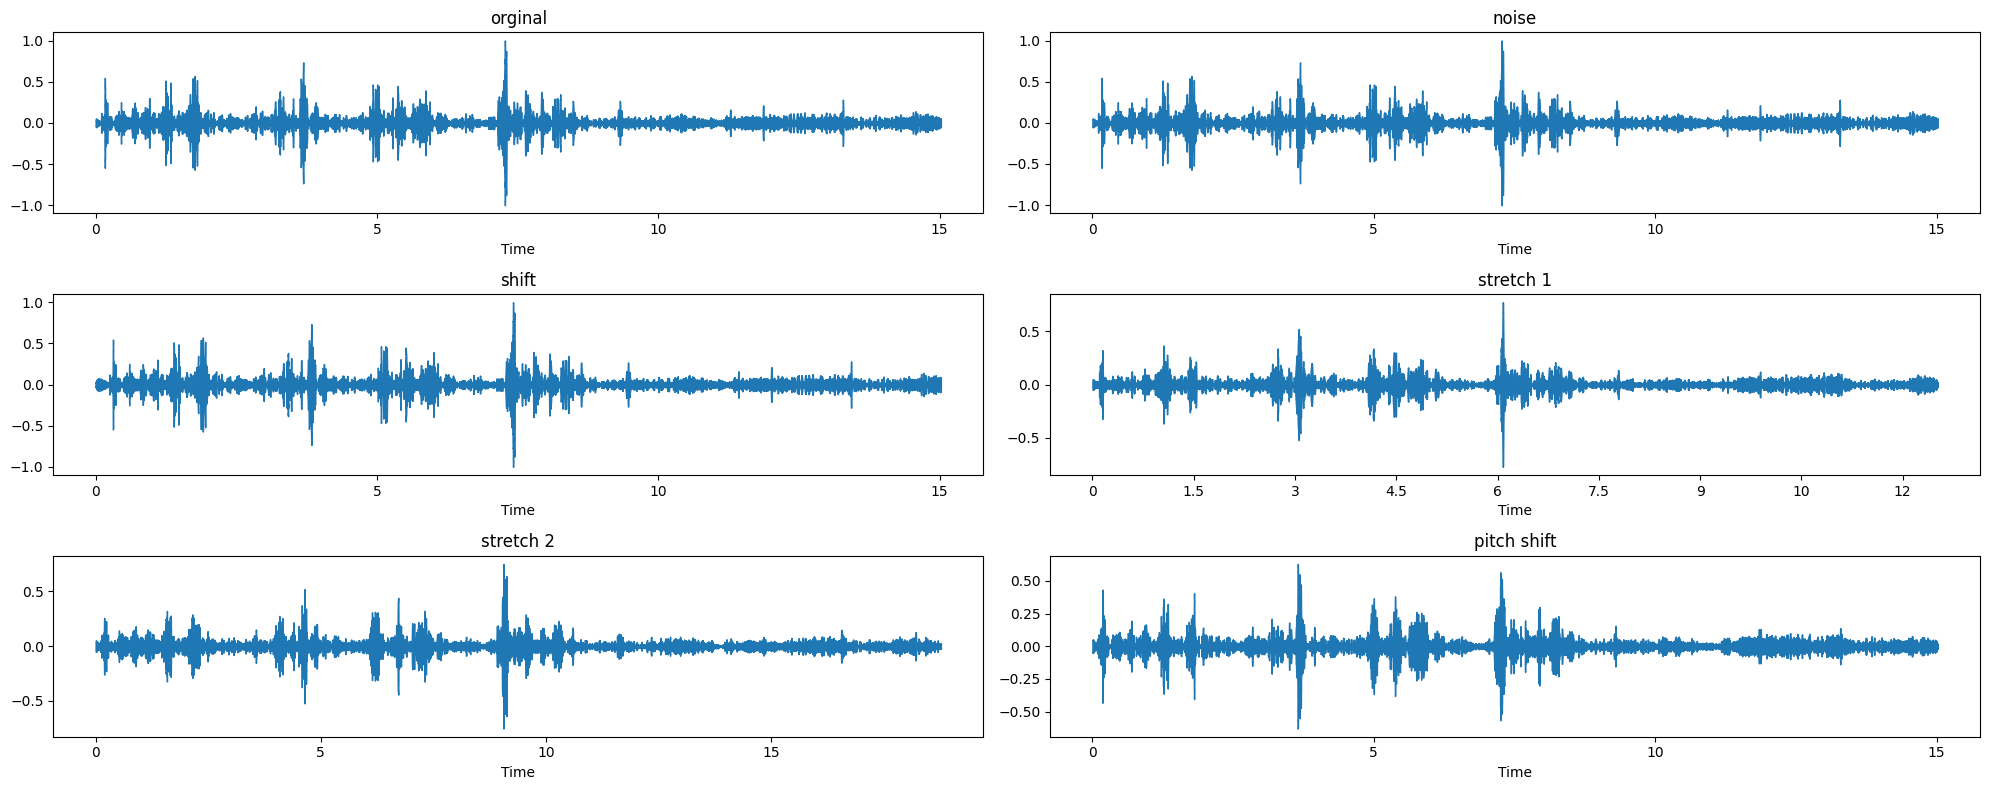

In [ ]:
show_audio('Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Lr_sc_Litt3200.wav')

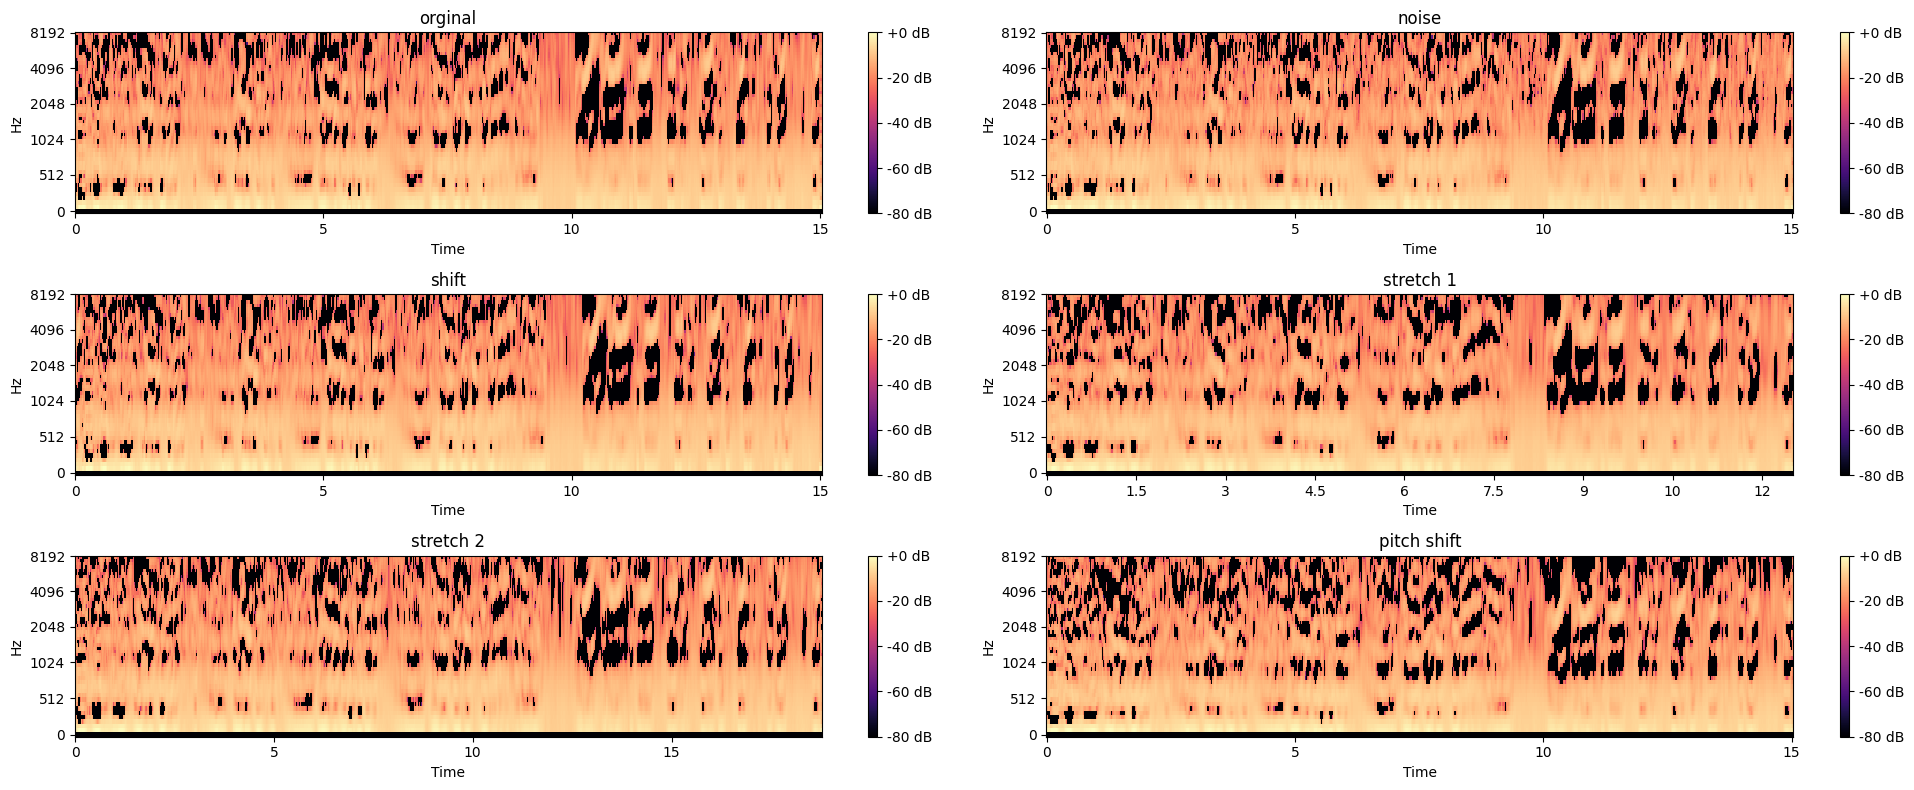

In [ ]:
show_audio_features('Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Lr_sc_Litt3200.wav')

In [ ]:
!pip install resampy
!pip install librosa
!pip install --index-url https://pypi.org/simple/ resampy

Looking in indexes: https://pypi.org/simple/


In [ ]:
import resampy

In [ ]:
def mfccs_feature_exteraction(dir_):
    '''
        Extract MFCC feature from the Sound data from the audio data.
        Augmentation of sound data by adding Noise, streaching and shifting.
        50 features are extracted from each audio data and used to train the model.
        Also, we remove .wav files with patient_id 103,108, and 115 to solve data imbalance, because they have unique lables.

        Args: dir_: Input directory to the Sound input file.

        Returns:
            X_data: Array of features extracted from the sound file.
            y_data: Array of target Labels.
    '''
    X_=[]
    y_=[]

    COPD=[]
    copd_count=0

    data = diagnosis_df
    features = 52

    for soundDir in (os.listdir(dir_)):
        if soundDir[-3:]=='wav'and soundDir[:3]!='103'and soundDir[:3]!='108'and soundDir[:3]!='115':

            p = list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0]
            if (p=='COPD'):
                if (soundDir[:6] in COPD) and copd_count<2:
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    COPD.append(soundDir[:6])
                    copd_count+=1
                    X_.append(mfccs)
                    y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])

                if (soundDir[:6] not in COPD):
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    COPD.append(soundDir[:6])
                    copd_count=0
                    X_.append(mfccs)
                    y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])

            if (p!='COPD'):
                if ((p == 'Bronchiectasis') or (p == 'Bronchiolitis')):
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs)
                    y_.append('Bronchiolitis')

                    data_noise = add_noise(data_x,0.001)
                    mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_noise)
                    y_.append('Bronchiolitis')

                    data_shift = shift(data_x,1600)
                    mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_shift)
                    y_.append('Bronchiolitis')

                    data_stretch = stretch(data_x,1.2)
                    mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append('Bronchiolitis')

                    data_stretch_2 = stretch(data_x,0.8)
                    mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=data_stretch_2, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch_2)
                    y_.append('Bronchiolitis')

                    data_pitch_shift = pitch_shift(data_x,3)
                    mfccs_stretch = np.mean(librosa.feature.melspectrogram(y=data_pitch_shift, sr=sampling_rate, n_mels=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append('Bronchiolitis')

                else:
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs)
                    y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])

                    data_noise = add_noise(data_x,0.001)
                    mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_noise)
                    y_.append(p)

                    data_shift = shift(data_x,1600)
                    mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_shift)
                    y_.append(p)

                    data_stretch = stretch(data_x,1.2)
                    mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append(p)

                    data_stretch_2 = stretch(data_x,0.8)
                    mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=data_stretch_2, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch_2)
                    y_.append(p)

                    data_pitch_shift = pitch_shift(data_x,3)
                    mfccs_stretch = np.mean(librosa.feature.melspectrogram(y=data_pitch_shift, sr=sampling_rate, n_mels=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append(p)



    X_data = np.array(X_)
    y_data = np.array(y_)


    return X_data, y_data

In [ ]:
x_mfccs, y = mfccs_feature_exteraction(audio_data)

In [ ]:
def augmented_lables_count(lables):
    unique, counts = np.unique(lables, return_counts=True)
    data_count = dict(zip(unique, counts))

    data = data_count

    courses = list(data.keys())
    values = list(data.values())

    fig = plt.figure(figsize = (10, 5))

    # creating the bar plot
    plt.bar(courses, values, color =['orange','green','blue','red','yellow','black'],
            width = 0.4)

    plt.xlabel("Diseases")
    plt.ylabel("Count")
    plt.title("Count of each disease")
    plt.show()

    print (data_count)

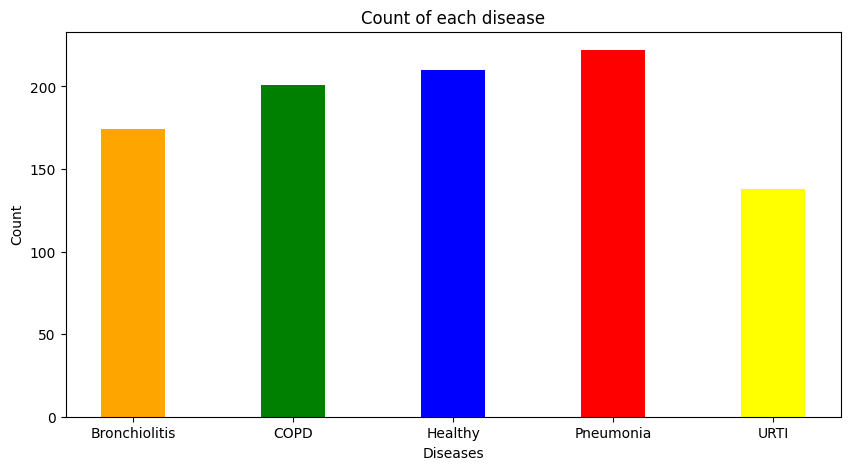

{'Bronchiolitis': 174, 'COPD': 201, 'Healthy': 210, 'Pneumonia': 222, 'URTI': 138}


In [ ]:
augmented_lables_count(y)

In [ ]:
y_data_encode = y.reshape(y.shape[0],1)
y_data_encode = np.where(y_data_encode == 'COPD',np.array([1,0,0,0,0]).reshape(1,5) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Bronchiolitis',np.array([0,1,0,0,0]).reshape(1,5) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Pneumonia',np.array([0,0,1,0,0]).reshape(1,5) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'URTI',np.array([0,0,0,1,0]).reshape(1,5) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Healthy',np.array([0,0,0,0,1]).reshape(1,5) , y_data_encode)

Y_data = y_data_encode.astype('float64')

In [ ]:
mfccs_features = np.array(x_mfccs)
lables = np.array(Y_data)

mfccs_features.shape , lables.shape

((945, 52), (945, 5))

In [ ]:
mfcc_train, mfcc_val, lables_train, lables_val  = train_test_split(mfccs_features, lables, test_size=0.175, random_state=10)
mfcc_train, mfcc_test, lables_train, lables_test = train_test_split(mfcc_train, lables_train, test_size=0.075, random_state=10)

print (mfcc_train.shape, mfcc_val.shape, mfcc_test.shape)
print (lables_train.shape, lables_val.shape, lables_test.shape)

(720, 52) (166, 52) (59, 52)
(720, 5) (166, 5) (59, 5)


In [ ]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
#   plt.plot(epochs, loss, label='training_loss')
#   plt.plot(epochs, val_loss, label='val_loss')
#   plt.title('Loss')
#   plt.xlabel('Epochs')
#   plt.legend()
#   plt.grid()


  # Plot accuracy
  plt.figure()
  plt.grid()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [ ]:
x_train_gru = np.expand_dims(mfcc_train,axis=1)
x_val_gru = np.expand_dims(mfcc_val,axis=1)
x_test_gru = np.expand_dims(mfcc_test,axis=1)

y_train_gru = np.expand_dims(lables_train,axis=1)
y_val_gru = np.expand_dims(lables_val,axis=1)
y_test_gru = np.expand_dims(lables_test,axis=1)

In [ ]:
Input_Sample = Input(shape=(1,52))

model_conv = Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(Input_Sample)
model_conv = MaxPooling1D(pool_size=2, strides = 2, padding = 'same')(model_conv)
model_conv = BatchNormalization()(model_conv)

model_conv = Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu')(model_conv)
model_conv = MaxPooling1D(pool_size=2, strides = 2, padding = 'same')(model_conv)
model_conv = BatchNormalization()(model_conv)

model_2_1 = GRU(32,return_sequences=True,activation='tanh',go_backwards=True)(model_conv)
model_2 = GRU(128,return_sequences=True, activation='tanh',go_backwards=True)(model_2_1)

model_3 = GRU(64,return_sequences=True,activation='tanh',go_backwards=True)(model_conv)
model_3 = GRU(128,return_sequences=True, activation='tanh',go_backwards=True)(model_3)

model_x = GRU(64,return_sequences=True,activation='tanh',go_backwards=True)(model_conv)
model_x = GRU(128,return_sequences=True, activation='tanh',go_backwards=True)(model_x)

model_add_1 = add([model_3,model_2,model_x])

model_5 = GRU(128,return_sequences=True,activation='tanh',go_backwards=True)(model_add_1)
model_5 = GRU(32,return_sequences=True, activation='tanh',go_backwards=True)(model_5)

model_6 = GRU(64,return_sequences=True,activation='tanh',go_backwards=True)(model_add_1)
model_6 = GRU(32,return_sequences=True, activation='tanh',go_backwards=True)(model_6)

model_add_2 = add([model_5,model_6,model_2_1])


model_7 = Dense(32, activation=None)(model_add_2)
model_7 = LeakyReLU()(model_7)
model_7 = Dense(128, activation=None)(model_7)
model_7 = LeakyReLU()(model_7)

model_9 = Dense(64, activation=None)(model_add_2)
model_9 = LeakyReLU()(model_9)
model_9 = Dense(128, activation=None)(model_9)
model_9 = LeakyReLU()(model_9)

model_add_3 = add([model_7,model_9])

model_10 = Dense(64, activation=None)(model_add_3)
model_10 = LeakyReLU()(model_10)

model_10 = Dense(32, activation=None)(model_10)
model_10 = LeakyReLU()(model_10)

model_10 = Dense(5, activation="softmax")(model_10)

gru_model = Model(inputs=Input_Sample, outputs = model_10)

gru_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1, 52)]              0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 1, 256)               66816     ['input_1[0][0]']             
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 1, 256)               0         ['conv1d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 1, 256)               1024      ['max_pooling1d[0][0]']   

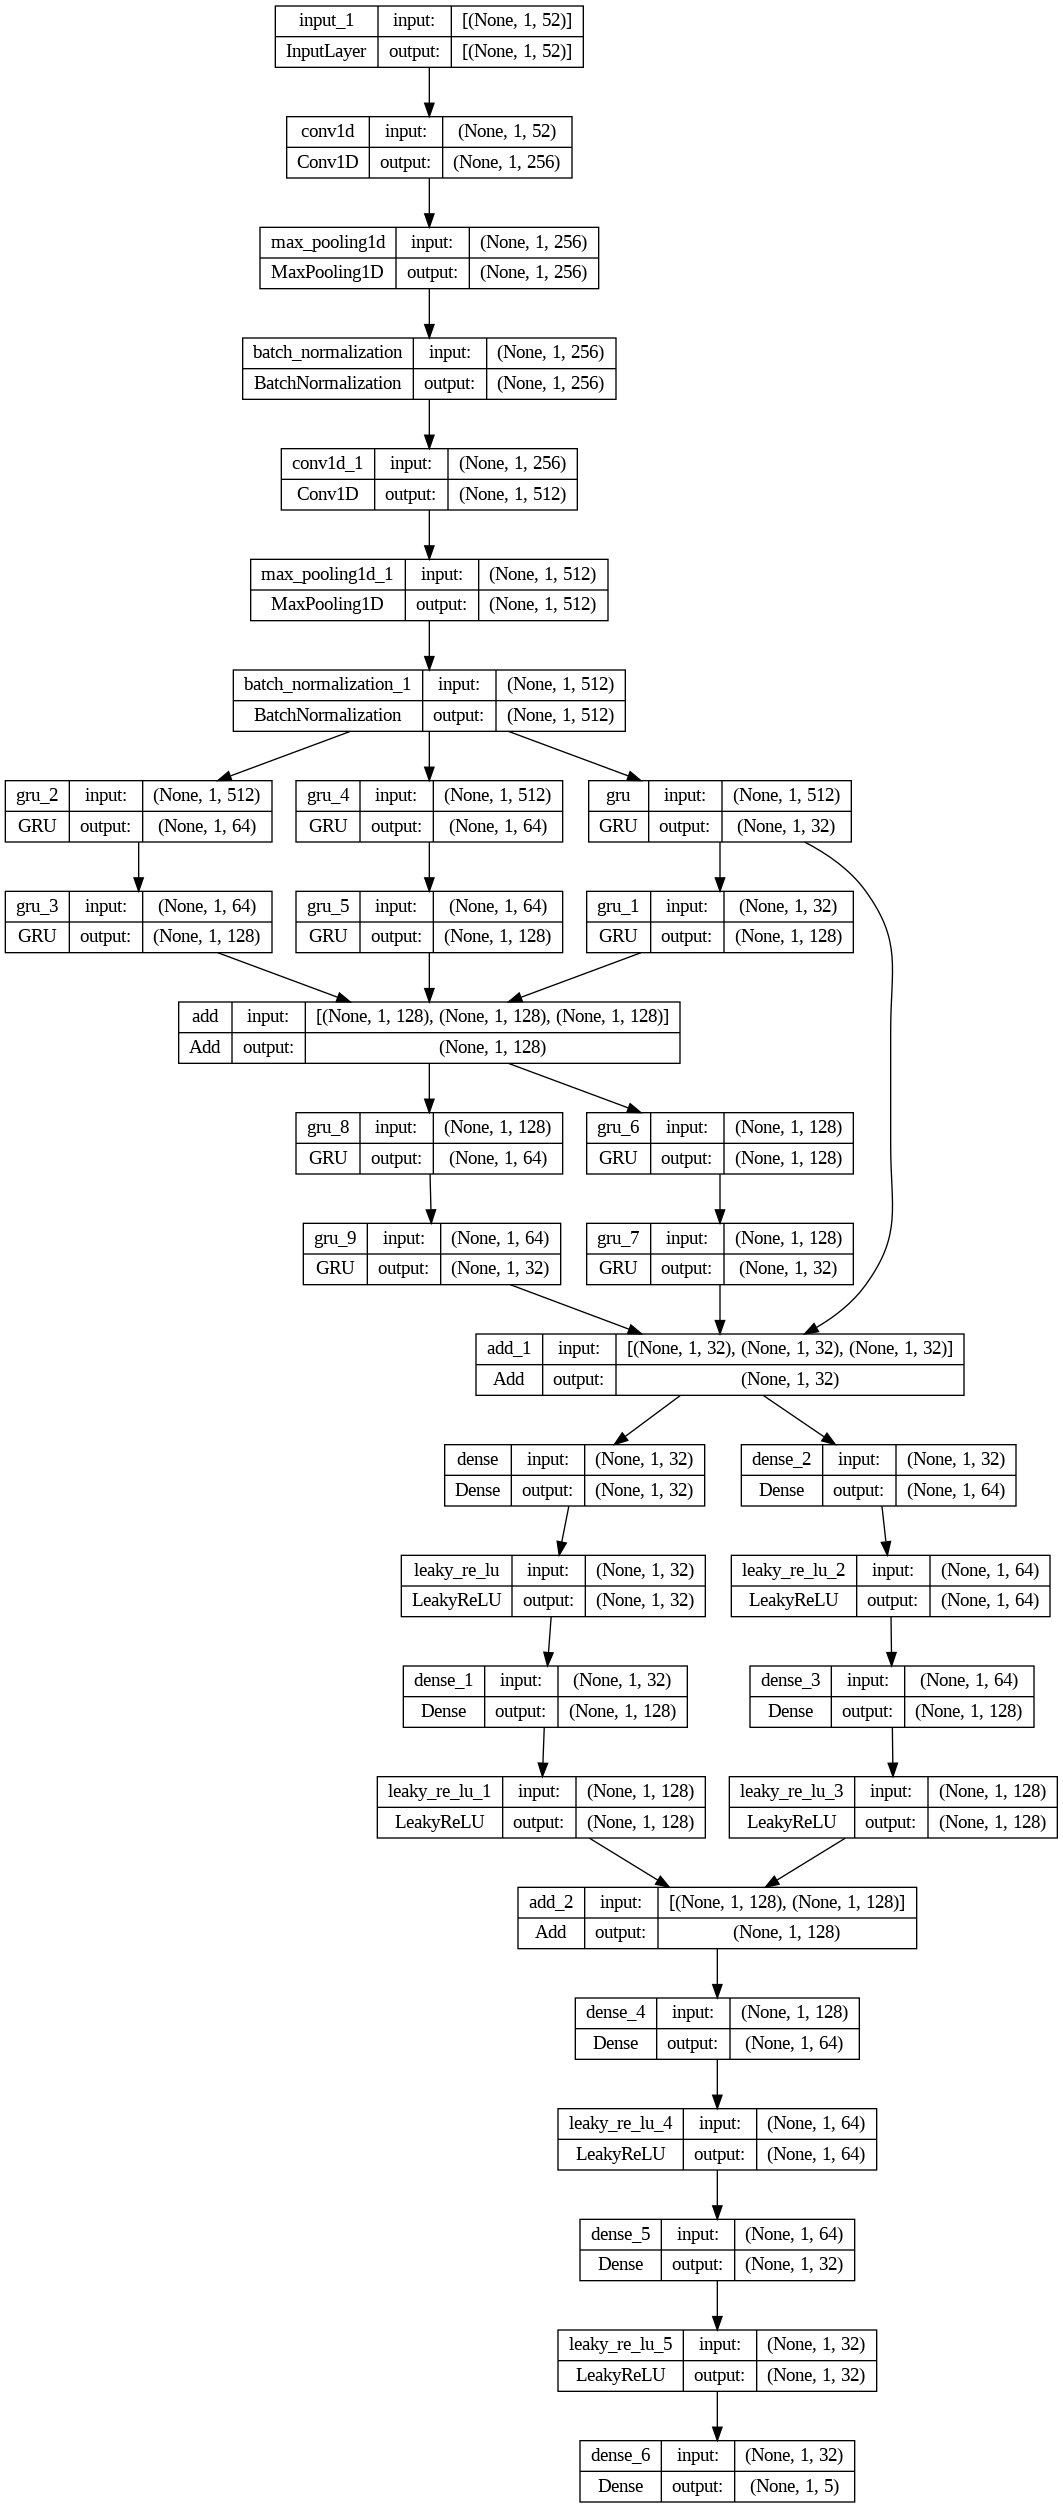

In [ ]:
tf.keras.utils.plot_model(gru_model, "gru_model.png", show_shapes=True)

In [ ]:
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0001)
gru_model.compile(optimizer=optimiser, loss='categorical_crossentropy',metrics=['accuracy'])

cb = [EarlyStopping(patience=300,monitor='accuracy',mode='max',restore_best_weights=True),
      ModelCheckpoint("/kaggle/working/diagnosis_GRU_CNN_1.h5",save_best_only=True)]

In [ ]:
history = gru_model.fit(x_train_gru, y_train_gru, batch_size=8, epochs=50, validation_data=(x_val_gru, y_val_gru), callbacks = cb)

Epoch 1/50
90/90 [==============================] - 27s 63ms/step - loss: 1.5135 - accuracy: 0.3500 - val_loss: 1.5840 - val_accuracy: 0.2711
Epoch 2/50
 1/90 [..............................] - ETA: 1s - loss: 1.4830 - accuracy: 0.5000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 [==============================] - 2s 19ms/step - loss: 1.2950 - accuracy: 0.4944 - val_loss: 1.3514 - val_accuracy: 0.5181
Epoch 3/50
90/90 [==============================] - 2s 19ms/step - loss: 1.1685 - accuracy: 0.5500 - val_loss: 1.1052 - val_accuracy: 0.6145
Epoch 4/50
90/90 [==============================] - 2s 24ms/step - loss: 1.0113 - accuracy: 0.5931 - val_loss: 0.9308 - val_accuracy: 0.6807
Epoch 5/50
90/90 [==============================] - 2s 28ms/step - loss: 0.9606 - accuracy: 0.6167 - val_loss: 0.7954 - val_accuracy: 0.7108
Epoch 6/50
90/90 [==============================] - 2s 24ms/step - loss: 0.8748 - accuracy: 0.6444 - val_loss: 0.7983 - val_accuracy: 0.7771
Epoch 7/50
90/90 [==============================] - 2s 22ms/step - loss: 0.8521 - accuracy: 0.6583 - val_loss: 0.7758 - val_accuracy: 0.7289
Epoch 8/50
90/90 [==============================] - 2s 21ms/step - loss: 0.8087 - accuracy: 0.6792 - val_loss: 0.6837 - val_accuracy: 0.7831
Epoch 9/50
90/90 [======

23/23 [==============================] - 1s 18ms/step - loss: 0.3148 - accuracy: 0.8681


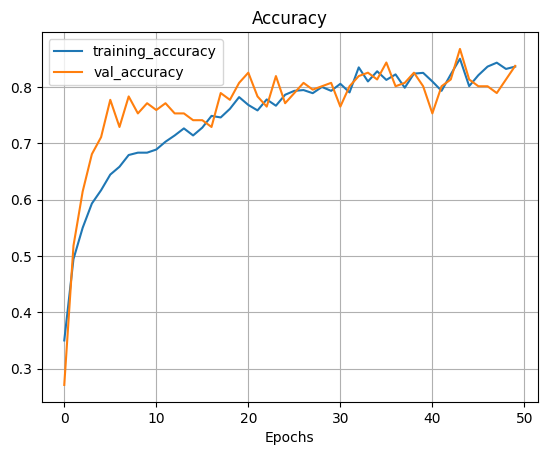

In [ ]:
gru_model.evaluate(x_train_gru, y_train_gru)

plot_loss_curves(history)

2/2 [==============================] - 9s 112ms/step


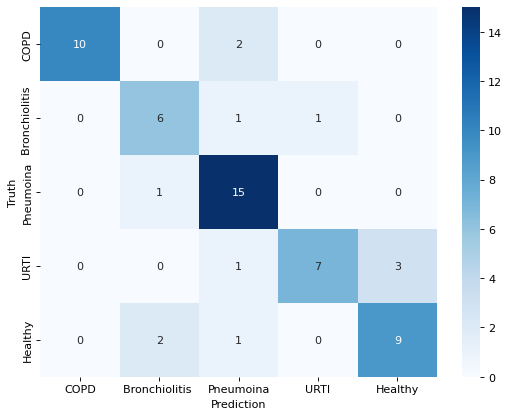

In [ ]:
classes = ["COPD" ,"Bronchiolitis ", "Pneumoina", "URTI", "Healthy"]

preds = gru_model.predict(x_test_gru)
classpreds = [np.argmax(t) for t in preds ]
y_testclass = [np.argmax(t) for t in y_test_gru]
cm = confusion_matrix(y_testclass, classpreds)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title('')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [ ]:
print(classification_report(y_testclass, classpreds, target_names=classes))

                precision    recall  f1-score   support

          COPD       1.00      0.83      0.91        12
Bronchiolitis        0.67      0.75      0.71         8
     Pneumoina       0.75      0.94      0.83        16
          URTI       0.88      0.64      0.74        11
       Healthy       0.75      0.75      0.75        12

      accuracy                           0.80        59
     macro avg       0.81      0.78      0.79        59
  weighted avg       0.81      0.80      0.80        59



In [ ]:
def gru_diagnosis_prediction(test_audio):
    data_x, sampling_rate = librosa.load(test_audio)
    data_x = stretch (data_x,1.2)

    features = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=52).T,axis = 0)

    features = features.reshape(1,52)

    test_pred = gru_model.predict(np.expand_dims(features, axis = 1))
    classpreds = classes[np.argmax(test_pred[0], axis=1)[0]]
    confidence = test_pred.T[test_pred[0].mean(axis=0).argmax()].mean()

    print (classpreds , confidence)

In [ ]:
val=[]
dir_= '/content/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/147_2b4_Ll_mc_AKGC417L.wav'
features = 52

soundDir = ''
data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
val.append(mfccs)
val = np.expand_dims(val,axis=1)

In [ ]:
classes[np.argmax(gru_model.predict(val))]

1/1 [==============================] - 0s 39ms/step


'COPD'

In [ ]:
gru_model.save('/content/drive/MyDrive/model/Respiratory_Disease_Classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
